In [2]:
import pandas as pd
import tabulate
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import scipy.cluster.hierarchy as sch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler



In [3]:
df_t1 = "cacl_t1_features.parquet"
df_t2 = "cacl_t2_features.parquet"
df_t1 = pd.read_parquet(df_t1)
df_t2 = pd.read_parquet(df_t2)

In [1]:
df_t1.head()

NameError: name 'df_t1' is not defined

In [7]:
len(df_t1)

801016

In [6]:
df_t1.ID.nunique()


801016

In [8]:
len(df_t2)

831077

In [9]:
df_t2.ID.nunique()

831077

In [10]:
df_t2.head()

,acl_id,abstract,full_text,title,text,raw_sequence_length,n_tokens,n_sentences,tokens_per_sentence,n_characters,...,n_work_of_art,n_quantity,n_norp,n_loc,n_event,n_ordinal,n_fac,n_law,n_language,ID
0,2024.acl-demos.12,"We present GenGO 1 , a system for exploring pa...","We present GenGO 1 , a system for exploring pa...",GenGO: ACL Paper Explorer with Semantic Features,"We present GenGO 1 , a system for exploring pa...",708,128,5,25.6,596,...,0,0,0,0,0,0,0,0,0,0
1,2024.acl-demos.12,"We present GenGO 1 , a system for exploring pa...","We present GenGO 1 , a system for exploring pa...",GenGO: ACL Paper Explorer with Semantic Features,We make our code available to foster open deve...,917,159,5,31.8,784,...,0,0,1,0,0,0,0,0,0,1
2,2024.acl-demos.12,"We present GenGO 1 , a system for exploring pa...","We present GenGO 1 , a system for exploring pa...",GenGO: ACL Paper Explorer with Semantic Features,A series of works on paper representation lear...,771,138,5,27.6,656,...,0,0,0,0,0,0,0,0,0,2
3,2024.acl-demos.12,"We present GenGO 1 , a system for exploring pa...","We present GenGO 1 , a system for exploring pa...",GenGO: ACL Paper Explorer with Semantic Features,As the NLP community also faces a large number...,802,151,5,30.2,684,...,0,0,2,0,0,0,0,0,0,3
4,2024.acl-demos.12,"We present GenGO 1 , a system for exploring pa...","We present GenGO 1 , a system for exploring pa...",GenGO: ACL Paper Explorer with Semantic Features,"In this paper, we describe our system, dubbed ...",765,137,5,27.4,653,...,0,0,0,0,0,0,0,0,0,4


In [26]:
def get_feature_impact(df):
    feature2importance = {}
    feature2coefficients = {}
    for feature in tqdm(df.columns):
        if feature == "after":
            continue
        # train a logistic regression model
        # get the feature importance
        # plot the feature importance
        model = LogisticRegression()
        model.fit(df[[feature]], df["after"])
        coeff = model.coef_[0]
        # get the R2 score
        variance_explained = model.score(df[[feature]], df["after"])
        # if it is a list, get the first element
        if isinstance(coeff, list):
            coeff = coeff[0]
        feature2coefficients[feature] = coeff
        
        # summarize feature importance
        feature2importance[feature] = variance_explained
    # sort the features by importance
    feature2importance = dict(sorted(feature2importance.items(), key=lambda item: item[1], reverse=True))
    feature2coefficients = dict(sorted(feature2coefficients.items(), key=lambda item: item[1], reverse=True))
    return feature2importance, feature2coefficients

In [16]:
columns_to_ignore = ["acl_id", "abstract", "full_text", "title", "text", "ID"]
feature_df_t1 = df_t1.drop(columns=columns_to_ignore)
feature_df_t1["after"] = 0
feature_df_t2 = df_t2.drop(columns=columns_to_ignore)
feature_df_t2["after"] = 1

In [17]:
# concat them together
feature_df = pd.concat([feature_df_t1, feature_df_t2])

In [14]:
def feature_selection(feature_df):
    # drop columns that have nan values
    feature_df = feature_df.dropna(axis=1)
    # drop columns that have only one value
    feature_df = feature_df.loc[:, feature_df.nunique() > 1]
    feature2importance = get_feature_impact(feature_df)
    # sort the feature2importance by  absolute value
    feature2importance = dict(sorted(feature2importance.items(), key=lambda item: abs(item[1]), reverse=True))
    # only get the top 75
    feature2importance = dict(list(feature2importance.items())[:75])
    # do hierarchical clustering using spearman correlation and the top 75 features
    # get the top 75 features
    top_features = list(feature2importance.keys())
    # get the spearman correlation matrix
    spearman_corr = feature_df[top_features].corr(method="spearman")
    distance_matrix = 1 - spearman_corr
    # convert the distance matrix to a condensed form
    condensed_distance_matrix = squareform(distance_matrix)
    # do hierarchical clustering
    linkage_matrix = sch.linkage(condensed_distance_matrix, method="ward")
    plt.figure(figsize=(20, 10))
    dendrogram = sch.dendrogram(linkage_matrix, labels=spearman_corr.columns, leaf_rotation=90)
    # plot the dendrogram
    plt.savefig("dendrogram.png", dpi=300)

100%|██████████| 319/319 [03:58<00:00,  1.34it/s]


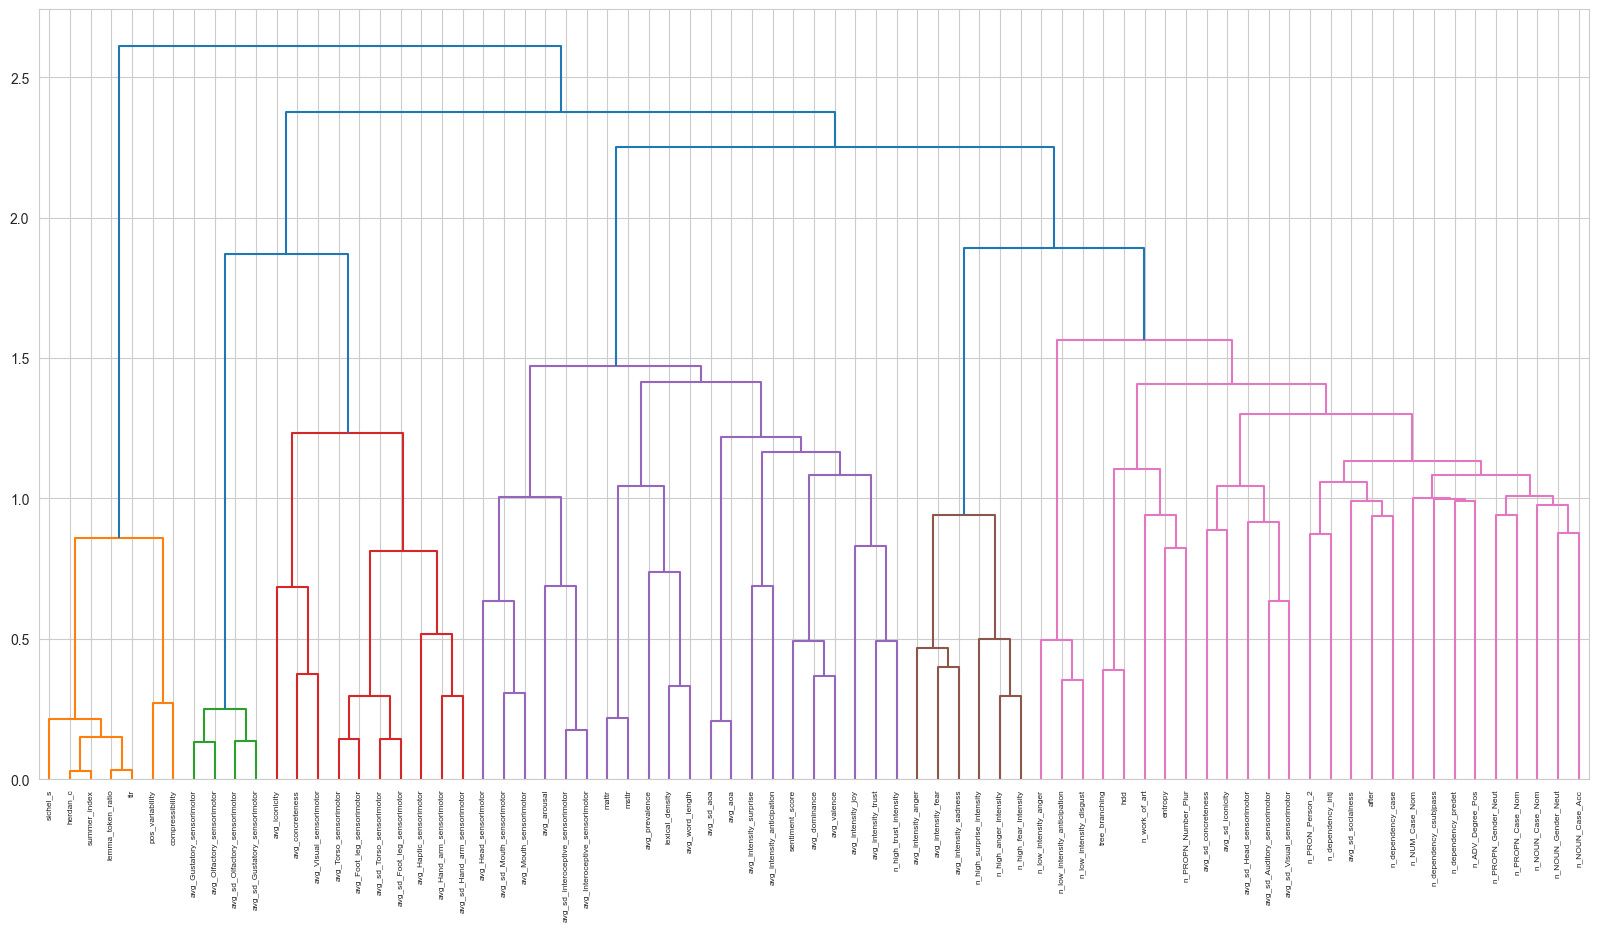

In [20]:
feature_selection(feature_df)

In [19]:
# convert infinities to nan
feature_df = feature_df.replace([float('inf'), float('-inf')], float('nan'))
# fill nan values with the mean
feature_df = feature_df.fillna(feature_df.mean())

In [22]:
feature2importance = get_feature_impact(feature_df)

100%|██████████| 319/319 [04:00<00:00,  1.32it/s]


In [28]:
# convert importance to one number (it is a one-element array)
feature2importance, feature2coefficients = get_feature_impact(feature_df)

# convert it to a dataframe
feature_impact_df = pd.DataFrame(feature2importance.items(), columns=["feature", "importance"])
# add the coefficients
feature_impact_df["coefficients"] = feature_impact_df["feature"].map(feature2coefficients)
# round to 3 decimal places
feature_impact_df["importance"] = feature_impact_df["importance"].round(3)
feature_impact_df["coefficients"] = feature_impact_df["coefficients"].round(3)
# save it to a csv file
feature_impact_df.to_csv("feature_impact.csv", index=False)

  2%|▏         | 5/319 [00:05<05:54,  1.13s/it]


KeyboardInterrupt: 

In [29]:
feature2importance


{'n_low_intensity_anticipation': 0.5426290045971645,
 'n_low_prevalence': 0.5369589845676687,
 'avg_Head_sensorimotor': 0.5348610649025515,
 'n_low_intensity_disgust': 0.5345577733621797,
 'avg_arousal': 0.5334898195139616,
 'avg_aoa': 0.5330560207047025,
 'n_high_synsets': 0.5322999363394121,
 'avg_n_synsets_noun': 0.5322239602767734,
 'avg_n_synsets': 0.5317031566215896,
 'n_high_Head_sensorimotor': 0.5308557784390963,
 'avg_sd_aoa': 0.5295856302306302,
 'n_dependency_auxpass': 0.5290942366642097,
 'n_monosyllables': 0.5288663084762939,
 'n_VERB_Aspect_Prog': 0.528681270001158,
 'avg_word_length': 0.5280379243094603,
 'n_high_synsets_noun': 0.5278191867742831,
 'n_dependency_nsubjpass': 0.5272297595786515,
 'avg_sd_Interoceptive_sensorimotor': 0.5269338205604706,
 'avg_Interoceptive_sensorimotor': 0.5268946071087861,
 'n_low_intensity_anger': 0.5261403608740434,
 'avg_prevalence': 0.5255962742319218,
 'n_low_intensity_sadness': 0.5255025295739887,
 'n_high_aoa': 0.5254798592972336,
 

In [32]:
feature2coefficients

{'sentiment_score': 3.831479527458652,
 'avg_arousal': 2.60843451594671,
 'mattr': 2.0113628528337624,
 'avg_dominance': 1.8137368245096126,
 'msttr': 1.7744409965634471,
 'herdan_c': 1.7460043796908966,
 'avg_sd_Mouth_sensorimotor': 1.6382725992282787,
 'avg_valence': 1.4412944454480097,
 'tree_branching': 1.422708782711225,
 'sichel_s': 1.1319751096363295,
 'avg_Head_sensorimotor': 1.095984832018903,
 'summer_index': 1.0527972501483847,
 'avg_Torso_sensorimotor': 1.0225979654431323,
 'avg_sd_aoa': 0.9785530332721742,
 'avg_sd_Interoceptive_sensorimotor': 0.9497352054315551,
 'lexical_density': 0.7961468309708393,
 'avg_intensity_trust': 0.7784755704751184,
 'avg_Mouth_sensorimotor': 0.7688714666299363,
 'avg_sd_socialness': 0.7049294561113272,
 'avg_Foot_leg_sensorimotor': 0.6809919240237706,
 'avg_sd_Torso_sensorimotor': 0.661581342928593,
 'lemma_token_ratio': 0.6556722783387501,
 'avg_Hand_arm_sensorimotor': 0.5704419809179777,
 'avg_sd_Hand_arm_sensorimotor': 0.5522004827146825,


In [33]:
feature_impact_df = pd.DataFrame(feature2importance.items(), columns=["feature", "importance"])


In [34]:
# add the coefficients
feature_impact_df["coefficients"] = feature_impact_df["feature"].map(feature2coefficients)

In [35]:
# round to 3 decimal places
feature_impact_df["importance"] = feature_impact_df["importance"].round(3)

In [36]:
feature_impact_df["coefficients"] = feature_impact_df["coefficients"].round(3)


In [37]:
# save it to a csv file
feature_impact_df.to_csv("feature_impact.csv", index=False)

In [38]:
feature_impact_df

,feature,importance,coefficients
0,n_low_intensity_anticipation,0.543,-0.367
1,n_low_prevalence,0.537,-0.101
2,avg_Head_sensorimotor,0.535,1.096
3,n_low_intensity_disgust,0.535,-0.253
4,avg_arousal,0.533,2.608
...,...,...,...
313,avg_intensity_anticipation,0.504,0.228
314,avg_intensity_fear,0.502,0.421
315,avg_intensity_anger,0.501,0.359
316,avg_intensity_sadness,0.498,0.253


In [39]:
feature_df.head()

,raw_sequence_length,n_tokens,n_sentences,tokens_per_sentence,n_characters,avg_word_length,n_types,n_long_words,n_lemmas,n_VERB_VerbForm_Fin,...,n_work_of_art,n_quantity,n_norp,n_loc,n_event,n_ordinal,n_fac,n_law,n_language,after
0,748,124,5,24.8,639,5.153226,76,51,71,5,...,0,0,1,0,0,0,0,0,0,0
1,784,143,5,28.6,667,4.664336,96,53,88,2,...,0,0,1,0,0,0,0,0,1,0
2,620,123,5,24.6,525,4.268293,78,38,72,2,...,0,0,1,0,0,0,0,0,0,0
3,696,122,5,24.4,598,4.901639,77,46,76,3,...,0,0,1,0,0,0,0,0,0,0
4,657,124,5,24.8,554,4.467742,73,36,70,1,...,0,0,1,1,0,2,0,0,0,0


In [41]:
df_t1.head()

,acl_id,abstract,full_text,title,text,raw_sequence_length,n_tokens,n_sentences,tokens_per_sentence,n_characters,...,n_work_of_art,n_quantity,n_norp,n_loc,n_event,n_ordinal,n_fac,n_law,n_language,ID
0,2020.lrec-1.386,As part of constructing the NINJAL Parsed Corp...,As part of constructing the NINJAL Parsed Corp...,Constructing Web-Accessible Semantic Role Labe...,As part of constructing the NINJAL Parsed Corp...,748,124,5,24.8,639,...,0,0,1,0,0,0,0,0,0,0
1,2020.lrec-1.386,As part of constructing the NINJAL Parsed Corp...,As part of constructing the NINJAL Parsed Corp...,Constructing Web-Accessible Semantic Role Labe...,The annotation will also provide a language re...,784,143,5,28.6,667,...,0,0,1,0,0,0,0,0,1,1
2,2020.lrec-1.386,As part of constructing the NINJAL Parsed Corp...,As part of constructing the NINJAL Parsed Corp...,Constructing Web-Accessible Semantic Role Labe...,and they are widely used. The numbered semanti...,620,123,5,24.6,525,...,0,0,1,0,0,0,0,0,0,2
3,2020.lrec-1.386,As part of constructing the NINJAL Parsed Corp...,As part of constructing the NINJAL Parsed Corp...,Constructing Web-Accessible Semantic Role Labe...,"Also, none of the annotated corpora that are r...",696,122,5,24.4,598,...,0,0,1,0,0,0,0,0,0,3
4,2020.lrec-1.386,As part of constructing the NINJAL Parsed Corp...,As part of constructing the NINJAL Parsed Corp...,Constructing Web-Accessible Semantic Role Labe...,The semantic roles and frames are annotated ba...,657,124,5,24.8,554,...,0,0,1,1,0,2,0,0,0,4


In [48]:
# iterate over acl_id group
# import tqdm
from tqdm import tqdm
paper2vectors = {}
for _, paper in tqdm(df_t1.groupby("acl_id")):
    paperid = paper["acl_id"].values[0]
    # represent the paper as a vector, averaging the features
    # drop the columns that are not features
    paper = paper.drop(columns=columns_to_ignore)
    # replace nan and infinities with the mean
    paper = paper.replace([float('inf'), float('-inf')], float(0.0))
    # get an average vector (take the average over the rows, for each column)
    paper_vector = paper.mean(axis=0)
    paper2vectors[paperid] = paper_vector
# scale and center the vectors
paper_vectors = pd.DataFrame(paper2vectors).T
# replace nan values with 0
paper_vectors = paper_vectors.fillna(0)
# get cosine similarity between papers
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity_matrix_t1 = cosine_similarity(paper_vectors)
print(cosine_similarity_matrix_t1.shape)

100%|██████████| 20259/20259 [01:03<00:00, 321.29it/s]


(20259, 20259)


In [49]:
paper2vectors = {}
for _, paper in tqdm(df_t2.groupby("acl_id")):
    paperid = paper["acl_id"].values[0]
    # represent the paper as a vector, averaging the features
    # drop the columns that are not features
    paper = paper.drop(columns=columns_to_ignore)
    # replace nan and infinities with the mean
    paper = paper.replace([float('inf'), float('-inf')], float(0.0))
    # get an average vector (take the average over the rows, for each column)
    paper_vector = paper.mean(axis=0)
    paper2vectors[paperid] = paper_vector
# scale and center the vectors
paper_vectors = pd.DataFrame(paper2vectors).T
# replace nan values with 0
paper_vectors = paper_vectors.fillna(0)
# get cosine similarity between papers
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity_matrix_t2 = cosine_similarity(paper_vectors)
print(cosine_similarity_matrix_t2.shape)

100%|██████████| 17501/17501 [01:19<00:00, 219.94it/s]


(17501, 17501)


In [50]:
# mean and std of cosine similarity_t1
print("Mean of cosine similarity_t1: ", cosine_similarity_matrix_t1.mean())
print("Std of cosine similarity_t1: ", cosine_similarity_matrix_t1.std())

Mean of cosine similarity_t1:  0.9706663614995721
Std of cosine similarity_t1:  0.17817691893978244


In [51]:
print("Mean of cosine similarity_t2: ", cosine_similarity_matrix_t2.mean())
print("Std of cosine similarity_t2: ", cosine_similarity_matrix_t2.std())

Mean of cosine similarity_t2:  0.9817747244571956
Std of cosine similarity_t2:  0.135427460458309


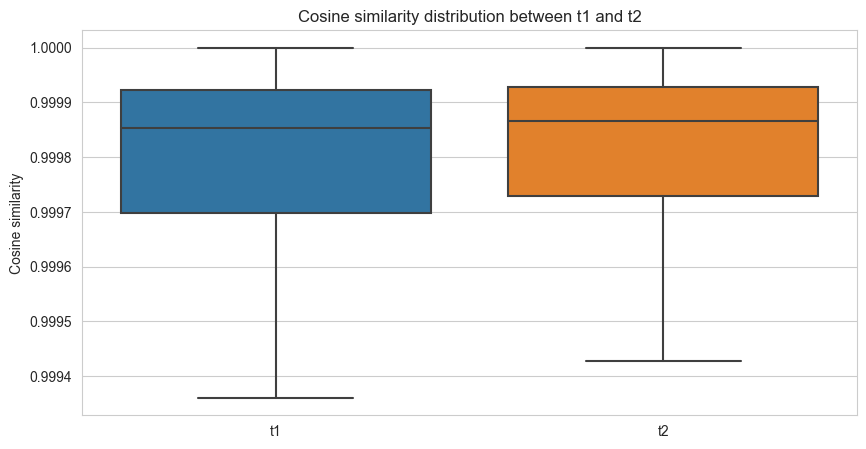

In [52]:
# plot a boxplot, compare the distribution of cosine similarity between t1 and t2
plt.figure(figsize=(10, 5))
sns.boxplot(data=[cosine_similarity_matrix_t1.flatten(), cosine_similarity_matrix_t2.flatten()], showfliers=False)
plt.xticks([0, 1], ["t1", "t2"])
plt.ylabel("Cosine similarity")
plt.title("Cosine similarity distribution between t1 and t2")
plt.savefig("cosine_similarity_distribution.png", dpi=300)

In [53]:
# flatten the matrix and cut out the diagonal
cosine_similarity_matrix_t1 = cosine_similarity_matrix_t1.flatten()
cosine_similarity_matrix_t2 = cosine_similarity_matrix_t2.flatten()
# do a t-test, to see if the cosine similarity between t1 and t2 is significantly different?
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(cosine_similarity_matrix_t1, cosine_similarity_matrix_t2)
print("T-statistic: ", t_stat)
print("P-value: ", p_value)

T-statistic:  -912.0594230053089
P-value:  0.0


In [56]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Dictionary to store paper vectors
paper2vectors = {}

# Compute feature vectors efficiently
for paper_id, paper in tqdm(df_t2.groupby("acl_id")):
    # Drop non-feature columns
    paper = paper.drop(columns=columns_to_ignore, errors="ignore")
    
    # Replace NaN and infinite values with column mean
    paper.replace([np.inf, -np.inf], np.nan, inplace=True)
    paper.fillna(paper.mean(), inplace=True)
    
    # Compute the average feature vector per paper
    paper2vectors[paper_id] = paper.mean(axis=0).values  # Ensure values are stored as an array

# Convert to DataFrame
paper_vectors = pd.DataFrame.from_dict(paper2vectors, orient="index")

# Replace remaining NaN values (if any) with 0
paper_vectors.fillna(0, inplace=True)

scaler = StandardScaler()  # Normalizes each feature to have mean=0, std=1
paper_vectors_scaled = pd.DataFrame(scaler.fit_transform(paper_vectors), index=paper_vectors.index)

# Compute cosine similarity
cosine_similarity_matrix_t2 = cosine_similarity(paper_vectors_scaled)

print("Cosine Similarity Matrix Shape:", cosine_similarity_matrix_t2.shape)

 60%|█████▉    | 10476/17501 [16:10<10:51, 10.79it/s] 


KeyboardInterrupt: 

In [ ]:
import numpy as np
columns_to_ignore = ["abstract", "full_text", "title", "text", "ID"]
tqdm.pandas()
# Drop non-feature columns
df_features_t2 = df_t2.drop(columns=columns_to_ignore, errors="ignore")

# Replace Inf/-Inf with NaN
df_features_t2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Compute the mean per paper, filling NaNs with column means
paper_vectors_t2 = df_features_t2.groupby("acl_id").progress_apply(lambda x: x.mean()).fillna(df_features_t2.mean())

# Reset the index to ensure paper IDs are in the index
#paper_vectors_t2.index.name = "acl_id"

100%|██████████| 17501/17501 [01:29<00:00, 196.46it/s]

In [7]:
paper_vectors_t2.head()

NameError: name 'paper_vectors_t2' is not defined

In [ ]:
# Drop non-feature columns
df_features_t1 = df_t1.drop(columns=columns_to_ignore, errors="ignore")
tqdm.pandas()

# Replace Inf/-Inf with NaN
df_features_t1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Compute the mean per paper, filling NaNs with column means
paper_vectors_t1 = df_features_t1.groupby("acl_id").progress_apply(lambda x: x.mean()).fillna(df_features_t1.mean())

# Reset the index to ensure paper IDs are in the index
#paper_vectors_t1.index.name = "acl_id"

In [ ]:
paper_vectors_t1.head()

In [ ]:
# Reset the index to ensure paper IDs are in the index
paper_vectors_t2.index.name = "acl_id"